# EDA of raw sleep data set provided by Child Mind Institute  

[Whole data Set](https://www.kaggle.com/c/child-mind-institute-detect-sleep-states/data?select=train_events.csv)

Within the scope of our project, we'll focus solely on analyzing 'train_events.csv' and 'train_series.parquet'.

The raw data is describes as: 
- 500 multi-day recordings of wrist-worn accelerometer data.
- annotated with two event types: onset, the beginning of sleep, and wakeup, the end of sleep.
- Sleep periods must be at least 30 minutes in length.
- no more than one sleep period should be assigned per night. 
- The longest sleep window during the night is the only one which is recorded
- If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.



In [3]:
# import of libraries: 
import pandas as pd
import numpy as np 
import missingno as msn
import plotly.express as px
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone



In [30]:
df_series = pd.read_parquet('train_series.parquet') # contains actual measurement data
df_events = pd.read_csv('train_events.csv') # contains metadata

## Let's check data completeness first

#### train time series 

In [31]:
df_series.head(10)

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215
5,038441c925bb,5,2018-08-14T15:30:25-0400,2.6367,0.0217
6,038441c925bb,6,2018-08-14T15:30:30-0400,2.6367,0.0217
7,038441c925bb,7,2018-08-14T15:30:35-0400,2.6367,0.0218
8,038441c925bb,8,2018-08-14T15:30:40-0400,2.7980,0.0223
9,038441c925bb,9,2018-08-14T15:30:45-0400,3.0847,0.0217


In [2]:
df_series.tail(10)

NameError: name 'df_series' is not defined

In [33]:
df_series.isna().sum() # no missing values :) 

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

Column descriptions: 
- step: An integer timestep for each observation within a series.
- series_id: Unique identifier for each accelerometer series.
- timestamp: A corresponding datetime with ISO 8601 format %Y-%m-%dT%H:%M:%S%z.
- anglez: metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body
- enmo: ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features

- enmo & angelz have been calculated with GGIR package

In [35]:
df_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


In [36]:
n_series = len(df_series.series_id.unique()) #277 series_id
t_min = df_series.timestamp.min() # '2017-08-04T17:30:00-0400'
t_max = df_series.timestamp.max() # '2019-07-09T09:44:55-0400'
# a long duration of recordings :O

#### train events 

In [116]:
df_events.head(10)
# as expected we have missing values 

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN


In [117]:
df_events.tail(10)

,series_id,night,event,step,timestamp
14498,fe90110788d2,31,onset,522852.0,2017-09-03T23:41:00-0400
14499,fe90110788d2,31,wakeup,529104.0,2017-09-04T08:22:00-0400
14500,fe90110788d2,32,onset,538956.0,2017-09-04T22:03:00-0400
14501,fe90110788d2,32,wakeup,547152.0,2017-09-05T09:26:00-0400
14502,fe90110788d2,33,onset,556560.0,2017-09-05T22:30:00-0400
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN
14507,fe90110788d2,35,wakeup,NaN,NaN


In [118]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


In [119]:
# let's qualify the missing values 
df_events.isna().sum()/df_events.count()


series_id    0.000000
night        0.000000
event        0.000000
step         0.513615
timestamp    0.513615
dtype: float64

<Axes: >

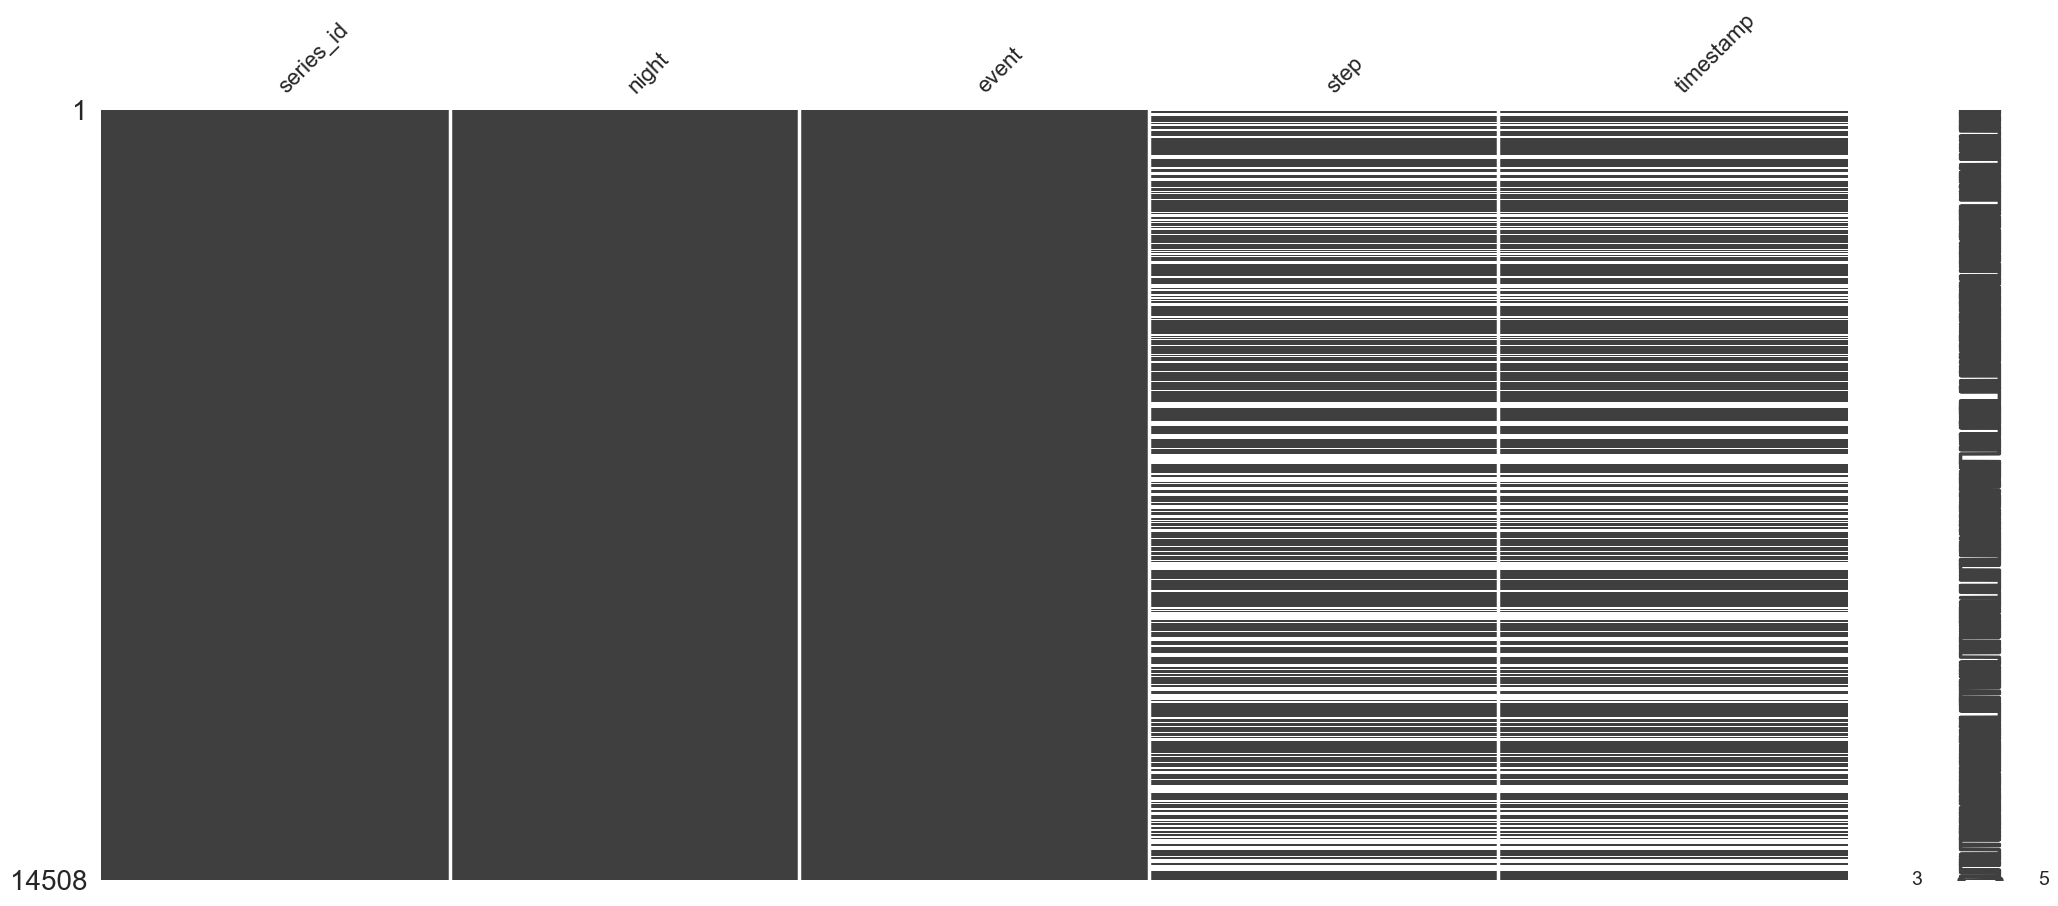

In [120]:
# let's see where they are 
msn.matrix(df_events)


In [121]:
df_events_plt = df_events.copy()
df_events_plt['timestamp'] = pd.to_datetime(df_events_plt['timestamp'], infer_datetime_format=True, utc=True) # conversion of timestamp

# plotting of 
pivot = pd.pivot_table(df_events_plt, index='series_id', columns='event', values='timestamp', aggfunc=['min', 'max'])
pivot.columns = [f'{level}_{col}_ts' for level, col in pivot.columns]

events_summary = df_events_plt \
    .groupby('series_id').agg({'series_id': 'count', 'step': 'count'}) \
    .rename({'series_id': 'count_events', 'step': 'count_non_null_events'}, axis=1) \
    .join(pivot, how='left')

events_summary.insert(
    2, 'pct_non_null_events', events_summary.count_non_null_events / events_summary.count_events
)

events_summary = events_summary.sort_values(['pct_non_null_events', 'count_non_null_events'], ascending=[False, True])

complete_series = events_summary.query('pct_non_null_events == 1.0')
empty_series    = events_summary.query('pct_non_null_events == 0.0')
incomplete_series = events_summary.query('(pct_non_null_events > 0.0) & (pct_non_null_events < 1.0)')

summary_evt = {
    'event_coverage': ['Full', 'Partial', 'Missing'],
    'series_count': [complete_series.shape[0], incomplete_series.shape[0], empty_series.shape[0]]
}

agg_data = pd.DataFrame(summary_evt)
fig = px.bar(agg_data, x='event_coverage', y='series_count', 
             title='Number of series with full, partial, and missing event label coverage',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()


/var/folders/wp/gjgrnkqd0mq5nfzdmnd4yvl80000gn/T/ipykernel_973/759540684.py:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [7]:
df_comb = pd.merge(df_series, df_events, on=['series_id', 'timestamp'], how='left')
#df_comb.to_parquet('merged_df.parquet') # let's ave the data so we can reload it to avoid the huge merging time 

NameError: name 'df_series' is not defined

### Merging 
we merge the event data with the series data to add the labels to the time series data 

In [4]:
df_comb = pd.read_parquet('merged_df.parquet')

### Random patient
before we dive into our the data of the whole, let's look at a random patient

let's look at our whole set to get a better overview

In [5]:
seed_value = 42
random.seed(seed_value)

random_entree = random.choice(df_comb.series_id.unique()) # = '33ceeba8918a'


df_randpat = df_comb.loc[df_comb['series_id'] == random_entree]

In [63]:
df_randpat.head()

,series_id,step_x,timestamp,anglez,enmo,night,event,step_y,hour
27418320,33ceeba8918a,0,2019-02-05 17:30:00,-84.892799,0.0129,NaN,None,NaN,17
27418321,33ceeba8918a,1,2019-02-05 17:30:05,-84.892799,0.0129,NaN,None,NaN,17
27418322,33ceeba8918a,2,2019-02-05 17:30:10,-84.865799,0.0127,NaN,None,NaN,17
27418323,33ceeba8918a,3,2019-02-05 17:30:15,-84.892799,0.0120,NaN,None,NaN,17
27418324,33ceeba8918a,4,2019-02-05 17:30:20,-84.802696,0.0121,NaN,None,NaN,17


In [64]:
df_randpat.tail()

,series_id,step_x,timestamp,anglez,enmo,night,event,step_y,hour
27837175,33ceeba8918a,418855,2019-03-01 23:14:35,-11.1346,0.0143,NaN,None,NaN,23
27837176,33ceeba8918a,418856,2019-03-01 23:14:40,-9.3668,0.0140,NaN,None,NaN,23
27837177,33ceeba8918a,418857,2019-03-01 23:14:45,-10.0855,0.0124,NaN,None,NaN,23
27837178,33ceeba8918a,418858,2019-03-01 23:14:50,-12.7016,0.0135,NaN,None,NaN,23
27837179,33ceeba8918a,418859,2019-03-01 23:14:55,-13.4635,0.0130,NaN,None,NaN,23


In [8]:
df_randpat["timestamp"] = pd.to_datetime(df_randpat["timestamp"])


/var/folders/wp/gjgrnkqd0mq5nfzdmnd4yvl80000gn/T/ipykernel_8018/3964982731.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_randpat["timestamp"] = pd.to_datetime(df_randpat["timestamp"])


Outlier 

<Axes: xlabel='event', ylabel='anglez'>

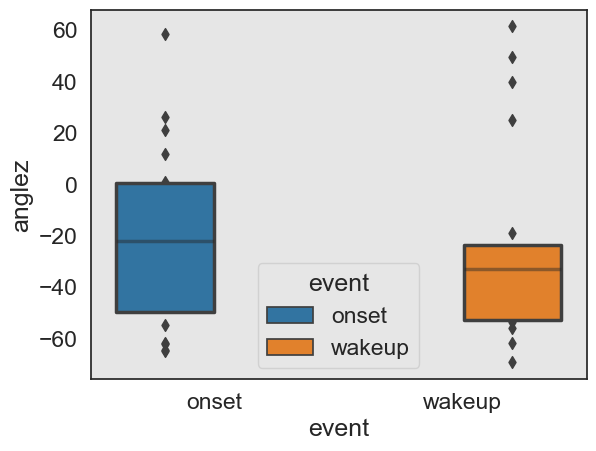

In [17]:
sns.boxenplot(df_randpat, x = 'event', y = 'anglez', hue = 'event')

<Axes: xlabel='event', ylabel='anglez'>

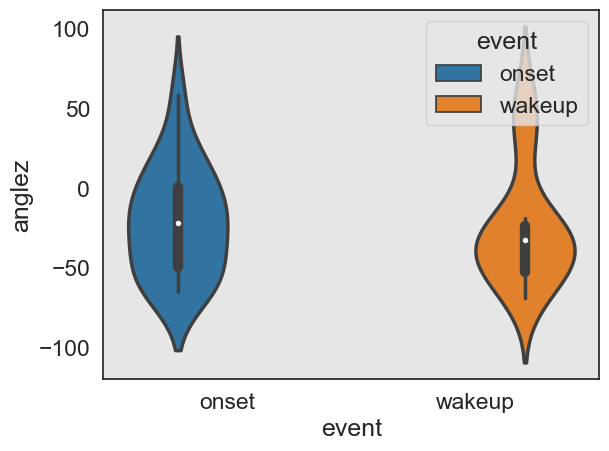

In [18]:
sns.violinplot(df_randpat, x= 'event', y ='anglez', hue='event')

<Axes: xlabel='event', ylabel='enmo'>

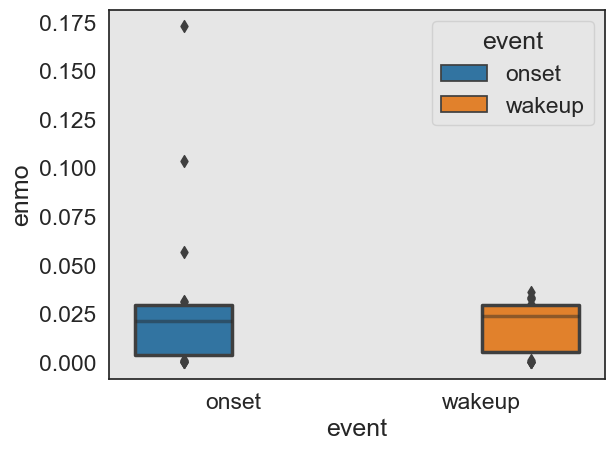

In [19]:
sns.boxenplot(df_randpat, x = 'event', y = 'enmo', hue = 'event')

<Axes: xlabel='event', ylabel='enmo'>

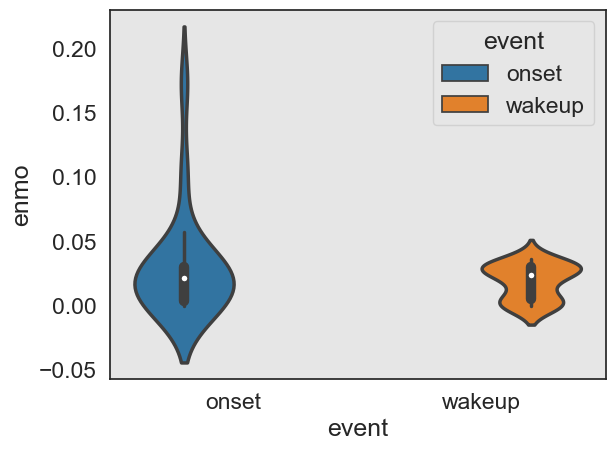

In [20]:
sns.violinplot(df_randpat, x= 'event', y ='enmo', hue='event')

so far nothing to be concerned of

<Axes: xlabel='anglez', ylabel='Count'>

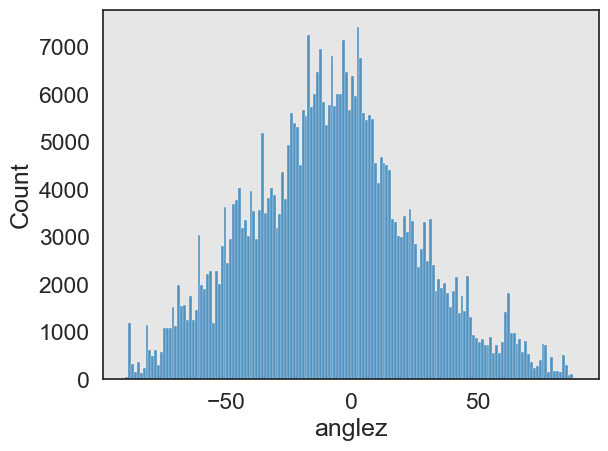

In [21]:
sns.histplot(df_randpat, x= 'anglez')

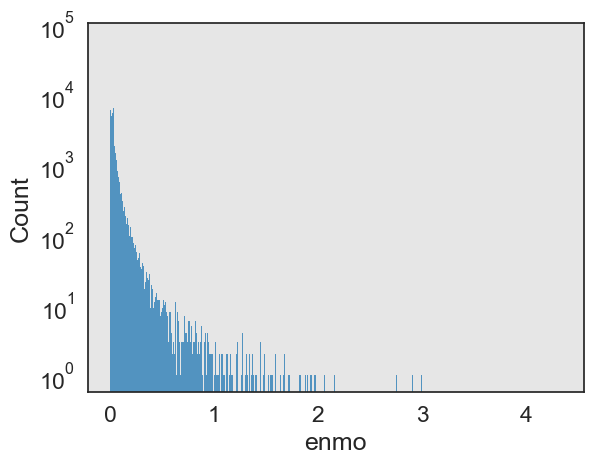

In [22]:
sns.histplot(df_randpat, x='enmo',)
plt.yscale('log')

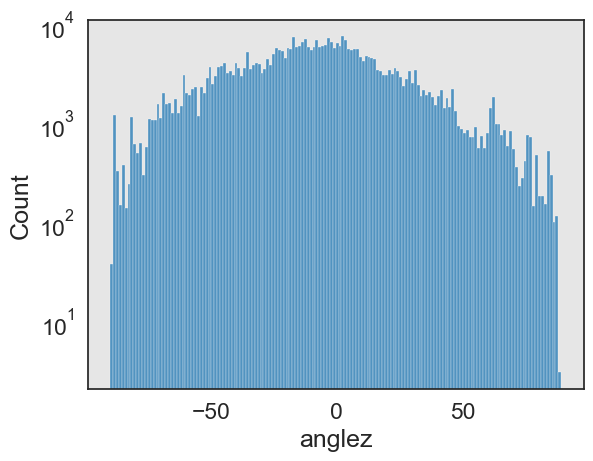

In [23]:
sns.histplot(df_randpat, x='anglez',)
plt.yscale('log')

now we know about the distribution of values. let's look at the timely distribution 

<Axes: xlabel='timestamp'>

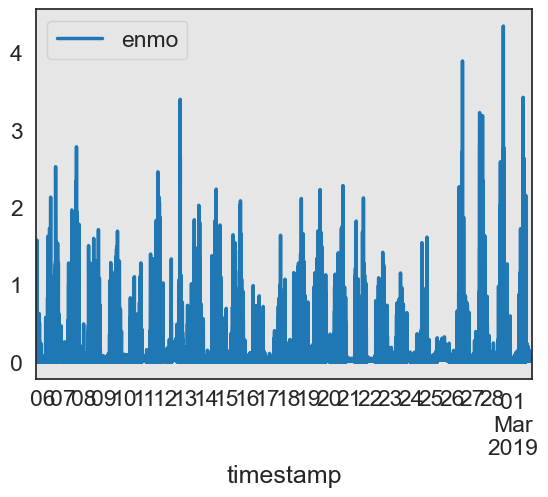

In [24]:
df_randpat.plot(x='timestamp', y='enmo')

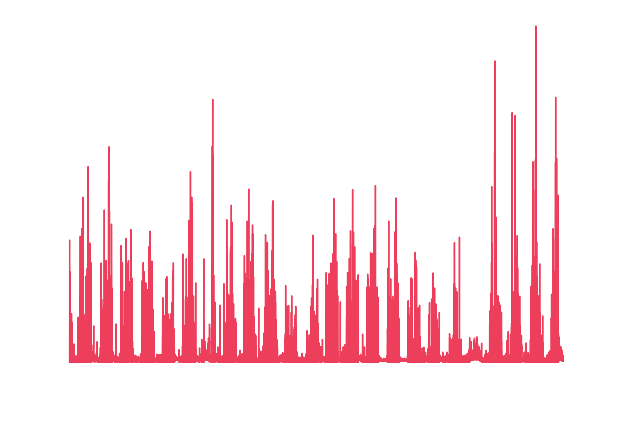

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_randpat is your DataFrame

# Set the style and context to have white labels
sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Create the plot
ax = sns.lineplot(x='timestamp', y='enmo', data=df_randpat, color='#ED3F5C', linewidth = 1)

# Customizing the plot
ax.set_ylabel('ENMO Magnitude', color='white')  # Set y-axis label color to white
ax.set_xlabel('', color='white')  # Set an empty string for x-axis label with white color

# Remove ticks and tick labels on the top and right
ax.tick_params(axis='both', which='both', top=False, right=False, labeltop=False, labelright=False, colors='white')

# Set x-axis limits to show only min and max timestamp
min_timestamp = df_randpat['timestamp'].min()
max_timestamp = df_randpat['timestamp'].max()
ax.set_xlim(min_timestamp, max_timestamp)

# Set background color to transparent
ax.patch.set_alpha(0)

# Remove the frame on the left and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set spines color to white
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Set color for x-axis label and ticks to white
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')  # Updated line

# Set color for y-axis ticks and labels to white
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')  # Updated line
ax.set_yticklabels([])  # No x tick labels


# Remove grid
ax.grid(False)

# Only show the first and last x-tick labels
ax.set_xticks([min_timestamp, max_timestamp])
ax.set_xticklabels([min_timestamp.date(), max_timestamp.date()])

# Save the plot with transparent background
plt.savefig(f'enmo_time_{random_entree}.png', bbox_inches='tight', transparent=True)

# Show the plot
plt.show()


rectangular plot for presentation

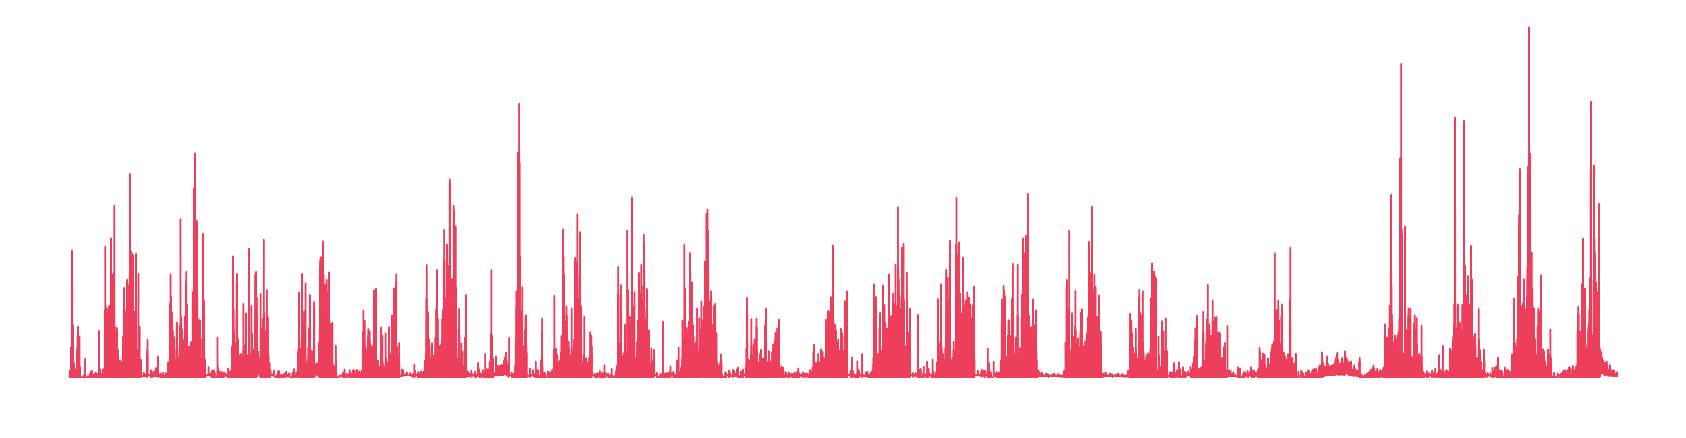

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df_randpat is your DataFrame

# Set the style and context to have white labels
sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Set the size of the figure
plt.figure(figsize=(20, 5))  # Adjust width and height as needed

# Create the plot
ax = sns.lineplot(x='timestamp', y='enmo', data=df_randpat, color='#ED3F5C', linewidth=1)

# Customizing the plot
ax.set_ylabel('ENMO Magnitude', color='white')  # Set y-axis label color to white
ax.set_xlabel('', color='white')  # Set an empty string for x-axis label with white color

# Remove ticks and tick labels on the top and right
ax.tick_params(axis='both', which='both', top=False, right=False, labeltop=False, labelright=False, colors='white')

# Set x-axis limits to show only min and max timestamp
min_timestamp = df_randpat['timestamp'].min()
max_timestamp = df_randpat['timestamp'].max()
ax.set_xlim(min_timestamp, max_timestamp)

# Set background color to transparent
ax.patch.set_alpha(0)

# Remove the frame on the left and top

# Remove the frame on the left and top
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set spines color to white
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Set color for x-axis label and ticks to white
ax.xaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')  # Updated line

# Set color for y-axis ticks and labels to white
ax.yaxis.label.set_color('white')
ax.tick_params(axis='y', colors='white')  # Updated line
ax.set_yticklabels([])  # No x tick labels


# Remove grid
ax.grid(False)

# Only show the first and last x-tick labels
ax.set_xticks([min_timestamp, max_timestamp])
ax.set_xticklabels([min_timestamp.date(), max_timestamp.date()])

# Save the plot with transparent background
plt.savefig(f'enmo_time_{random_entree}_rect.png', bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

we can see how ENMO changes over time and has a daily period. let's look at one day:

In [15]:
group_night_series = df_comb.groupby(['series_id', 'night']) # to get timestamp for both events per night 
group_series = df_comb.groupby('series_id')

wake_up_1 = group_night_series.get_group((random_entree, 1)).timestamp.max()
to_bed_1 = group_night_series.get_group((random_entree, 1)).timestamp.min()



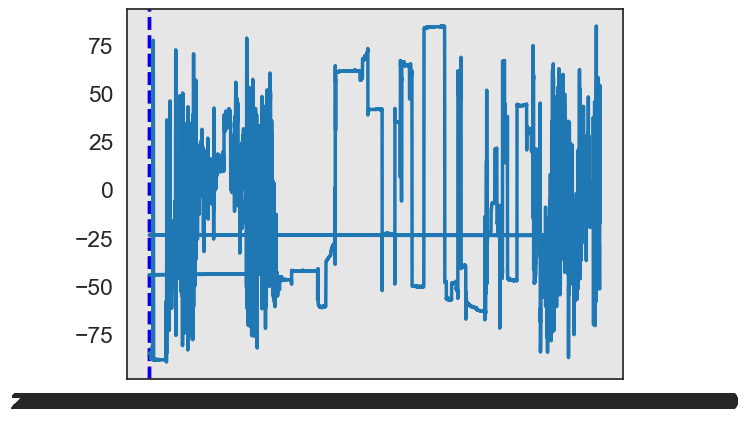

In [14]:
# analyis of 1st night for id: 038441c925bb

import matplotlib.pyplot as plt

sample_day = group_series.get_group(random_entree).head(11000) # 


to_bed = group_night_series.get_group((random_entree, 1)).timestamp.min() # onset time 2018-08-14T22:26:00-0400
wake_up = group_night_series.get_group((random_entree, 1)).timestamp.max() # wake up time 2018-08-15T06:41:00-0400


sleepy = to_bed
wakey =  wake_up
    
plt.axvline(x=sleepy, color='r', linestyle='--', label='to bed')
plt.axvline(x=wakey, color='b', linestyle='--', label='wake up')



plt.plot(sample_day['timestamp'], sample_day['anglez'])

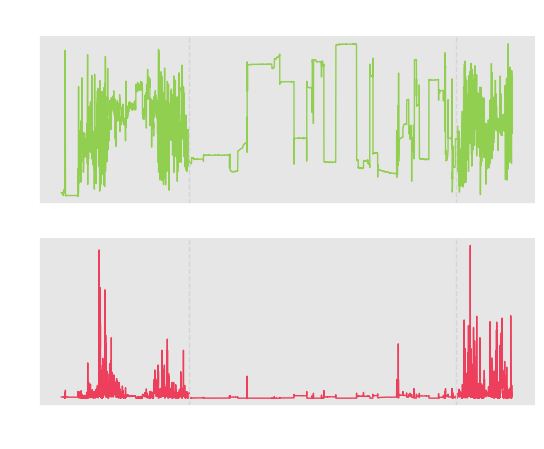

In [21]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.rcParams['text.color'] = 'white'  # Set all text color to white

fig, axs = plt.subplots(2)  # Create a figure with two subplots
fig.patch.set_facecolor('none')  # Make the background transparent


# First subplot for 'anglez'
axs[0].plot(sample_day['timestamp'], sample_day['anglez'], color='#91CF50', linewidth = 1)  # Set color to #91CF50
axs[0].axvline(x=sleepy, color='#D5D5D5', linestyle='--', linewidth=1, label='to bed')  # Set color to #D5D5D5 and linewidth to 0.5
axs[0].axvline(x=wakey, color='#D5D5D5', linestyle='--', linewidth=1, label='wake up')  # Set color to #D5D5D5 and linewidth to 0.5
axs[0].set_title('Angelz')  # Corrected title
axs[0].set_xticklabels([])  # No x tick labels


# Remove the frame on the left and top
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Set spines color to white
axs[0].spines['left'].set_color('white')
axs[0].spines['bottom'].set_color('white')


axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format the date with hour and minute
axs[1].set_yticks([])  # No y tick labels
axs[1].set_ylabel('Magnitude', color = 'white')  # Y-axis label



axs[0].set_yticks([])  # No y tick labels
axs[0].set_ylabel('Magnitude', color = 'white')  # Y-axis label


# Second subplot for 'enmo'
axs[1].plot(sample_day['timestamp'], sample_day['enmo'], color='#ED3F5C', linewidth = 1)  # Set color to #ED3F5C
axs[1].axvline(x=sleepy, color='#D5D5D5', linestyle='--', linewidth=1, label='to bed')  # Set color to #D5D5D5 and linewidth to 0.5
axs[1].axvline(x=wakey, color='#D5D5D5', linestyle='--', linewidth=1, label='wake up')  # Set color to #D5D5D5 and linewidth to 0.5
axs[1].set_title('ENMO')  # Corrected title
axs[1].set_xticks([sleepy, wakey])  # Set x-axis ticks at 'to bed' and 'wake up' times


# Remove the frame on the left and top
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Set spines color to white
axs[1].spines['left'].set_color('white')
axs[1].spines['bottom'].set_color('white')


axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format the date with hour and minute
axs[1].set_yticks([])  # No y tick labels
axs[1].set_ylabel('Magnitude', color = 'white')  # Y-axis label




# Change x-axis tick labels color to white
for label in axs[1].xaxis.get_ticklabels():
    label.set_color('white')

plt.show()

# Save the figure with a transparent background
fig.savefig('singe_night_angelz_enmo.png', transparent=True)


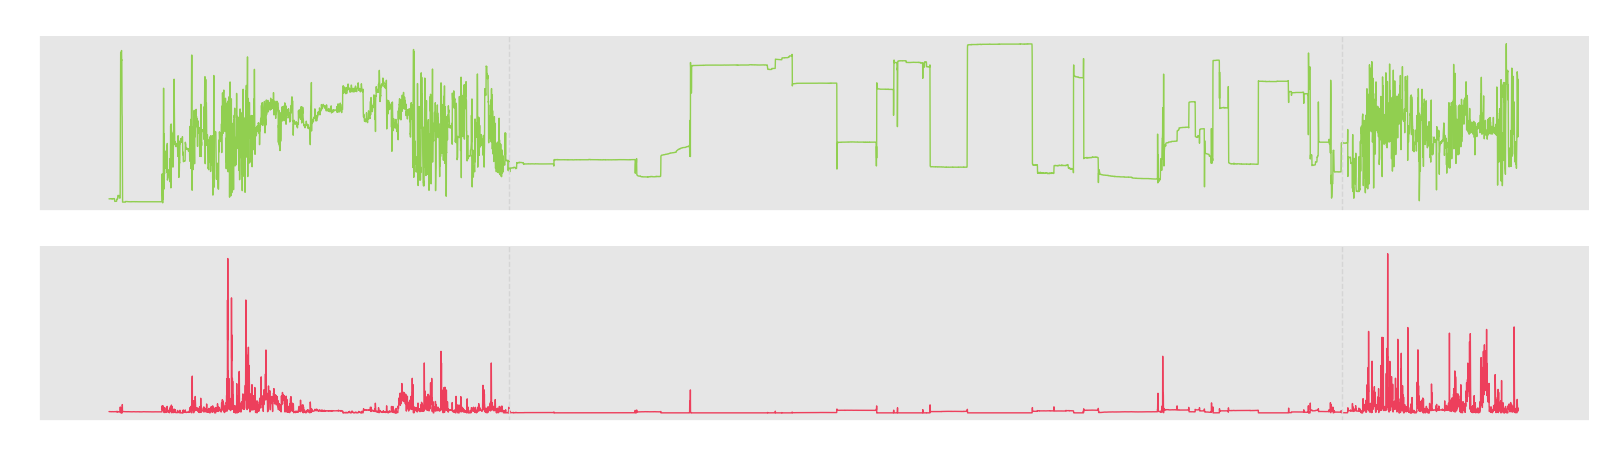

In [20]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.rcParams['text.color'] = 'white'  # Set all text color to white

# Set the figure size to 20x5 when creating subplots
fig, axs = plt.subplots(2, figsize=(20, 5))

fig.patch.set_facecolor('none')  # Make the background transparent

# First subplot for 'anglez'
axs[0].plot(sample_day['timestamp'], sample_day['anglez'], color='#91CF50', linewidth=1)  # Set color to #91CF50
axs[0].axvline(x=sleepy, color='#D5D5D5', linestyle='--', linewidth=1, label='to bed')  # Set color to #D5D5D5 and linewidth to 0.5
axs[0].axvline(x=wakey, color='#D5D5D5', linestyle='--', linewidth=1, label='wake up')  # Set color to #D5D5D5 and linewidth to 0.5
axs[0].set_title('Angelz')  # Corrected title
axs[0].set_xticklabels([])  # No x tick labels

# Remove the frame on the left and top
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Set spines color to white
axs[0].spines['left'].set_color('white')
axs[0].spines['bottom'].set_color('white')

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format the date with hour and minute
axs[1].set_yticks([])  # No y tick labels
axs[1].set_ylabel('Magnitude', color='white')  # Y-axis label

axs[0].set_yticks([])  # No y tick labels
axs[0].set_ylabel('Magnitude', color='white')  # Y-axis label

# Second subplot for 'enmo'
axs[1].plot(sample_day['timestamp'], sample_day['enmo'], color='#ED3F5C', linewidth=1)  # Set color to #ED3F5C
axs[1].axvline(x=sleepy, color='#D5D5D5', linestyle='--', linewidth=1, label='to bed')  # Set color to #D5D5D5 and linewidth to 0.5
axs[1].axvline(x=wakey, color='#D5D5D5', linestyle='--', linewidth=1, label='wake up')  # Set color to #D5D5D5 and linewidth to 0.5
axs[1].set_title('ENMO')  # Corrected title
axs[1].set_xticks([sleepy, wakey])  # Set x-axis ticks at 'to bed' and 'wake up' times

# Remove the frame on the left and top
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

# Set spines color to white
axs[1].spines['left'].set_color('white')
axs[1].spines['bottom'].set_color('white')

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format the date with hour and minute
axs[1].set_yticks([])  # No y tick labels
axs[1].set_ylabel('Magnitude', color='white')  # Y-axis label

# Change x-axis tick labels color to white
for label in axs[1].xaxis.get_ticklabels():
    label.set_color('white')

# Save the figure with a transparent background and specified size using dpi
fig.savefig('singe_night_angelz_enmo_rect.png', transparent=True, dpi=100)  # Adjust dpi as needed

plt.show()


## Now we look at all participants

In [26]:
# helper function to 
def none_to_str(dataframe, column):
    ''' 
    This function returns the given dataframe with 'none' strings in the given column instead of actual None values.
    '''
    events = []
    for j in dataframe.index:
        if dataframe[column][j] == None:
            events.append('None')
        else:
            events.append(dataframe[column][j])
    dataframe[column] = events
    return dataframe

df_comb2 = none_to_str(df_comb, 'event')

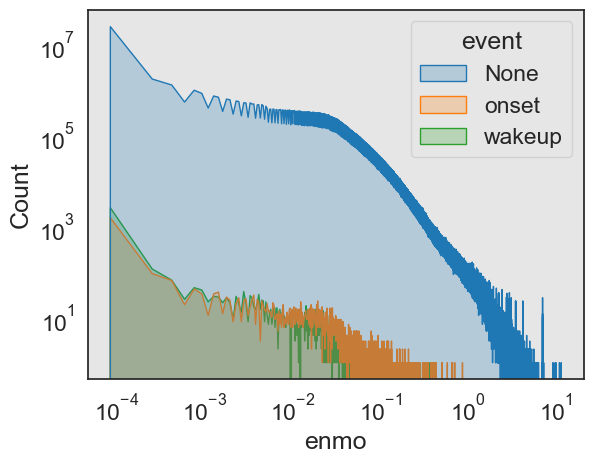

In [27]:
sns.histplot(df_comb2, x='enmo', hue = 'event', element = 'poly')
plt.yscale('log')
plt.xscale('log')

most data has no event label 

<Axes: xlabel='anglez', ylabel='Count'>

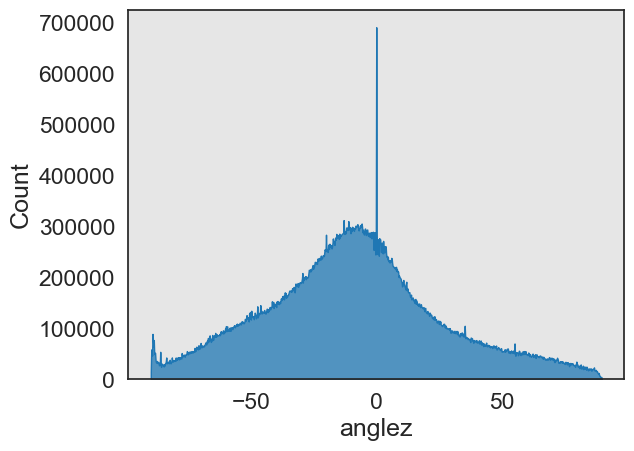

In [28]:
sns.histplot(df_comb2, x='anglez',element='poly', )


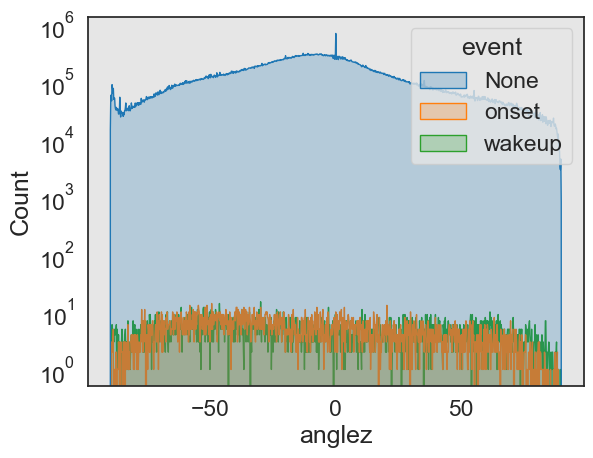

In [29]:
sns.histplot(df_comb2, x='anglez',element='poly', hue= 'event')
plt.yscale('log')

<Axes: xlabel='anglez', ylabel='Count'>

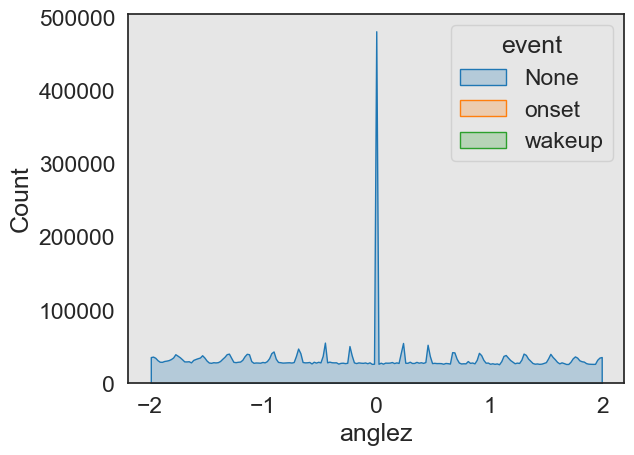

In [30]:
df_anglez_0 = df_comb2.query('anglez > -2 and anglez <2')
sns.histplot(df_anglez_0, x='anglez',element='poly', hue= 'event')

In [23]:

df_comb = pd.read_parquet('merged_df.parquet')
df_comb['timestamp'] = df_comb['timestamp'].apply(lambda ts: datetime.fromisoformat(ts.replace('Z', '+00:00')).astimezone(timezone.utc).replace(tzinfo=None))
df_comb['timestamp'] = df_comb['timestamp'] - pd.Timedelta(hours=4)
df_comb['hour'] = df_comb['timestamp'].dt.hour

In [58]:
# Group by "event" and "hour" and count occurrences
agg_data = df_comb[["event", "hour"]].groupby(["event", "hour"]).size().reset_index(name="count")

agg_data["hour"] = agg_data["hour"].astype(int)

color_map = {
    "wakeup": "#5BCFC5",
    "onset": "#9E61CD",
    # Add more classes if needed
}

# Create sunburst chart
fig = px.sunburst(
    agg_data,
    values='count',
    path=["event", "hour"],
    title="Events by hours in a day",
    color="event",
    height=600,
    color_discrete_map=color_map  # Use color_discrete_map here
)

# Update the layout to change the font color to white and set the background color to transparent
fig.update_layout(
    font=dict(color="white"),  # Add this line
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    uniformtext=dict(minsize=10, mode='hide')
)

# Display the figure
fig.show()

# Save the figure as a PNG
import plotly.offline as pyo

# Save the figure as an HTML file
pyo.plot(fig, filename='sunburst_chart.html')


'sunburst_chart.html'

from this plot we derive out baseline model: 
- Onset @ 22:30 
- Wake up @ 6:30